<a href="https://colab.research.google.com/github/Fethbita/TalTech_ITI8730_Data_Mining_Final_Project/blob/main/Final%20Project%20with%20CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import gzip
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
# https://stackoverflow.com/a/6252494/6077951
from scipy.stats import mode

In [3]:
def load_dataset(images_file, labels_file, mapping_file):
    with gzip.open(images_file, 'r') as infile:
        infile.read(16)
        images = infile.read()
    images = np.frombuffer(images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(-1, 28 * 28, 1).squeeze()
    images = torch.from_numpy(images).cuda()
    
    with gzip.open(labels_file, 'r') as infile:
        infile.read(8)
        labels = infile.read()
    labels = np.frombuffer(labels, dtype=np.uint8).astype(np.int64)

    with open(mapping_file, 'r') as infile:
        mapping = infile.read().splitlines()
    mapping = [int(i.split()[1]) for i in mapping]
    mapping = np.array(mapping)

    labels = mapping[labels]
    labels = torch.from_numpy(labels).cuda()

    return images, labels

In [4]:
dirname = "/content/gdrive/My Drive/TalTech/Data Mining/emnist/"
X_train, Y_train = load_dataset(dirname + 'emnist-balanced-train-images-idx3-ubyte.gz',
                                       dirname + 'emnist-balanced-train-labels-idx1-ubyte.gz',
                                       dirname + 'emnist-balanced-mapping.txt')

X_test, Y_test = load_dataset(dirname + 'emnist-balanced-test-images-idx3-ubyte.gz',
                                       dirname + 'emnist-balanced-test-labels-idx1-ubyte.gz',
                                       dirname + 'emnist-balanced-mapping.txt')

In [5]:
print(X_train.shape)
print(X_test.shape)

torch.Size([112800, 784])
torch.Size([18800, 784])


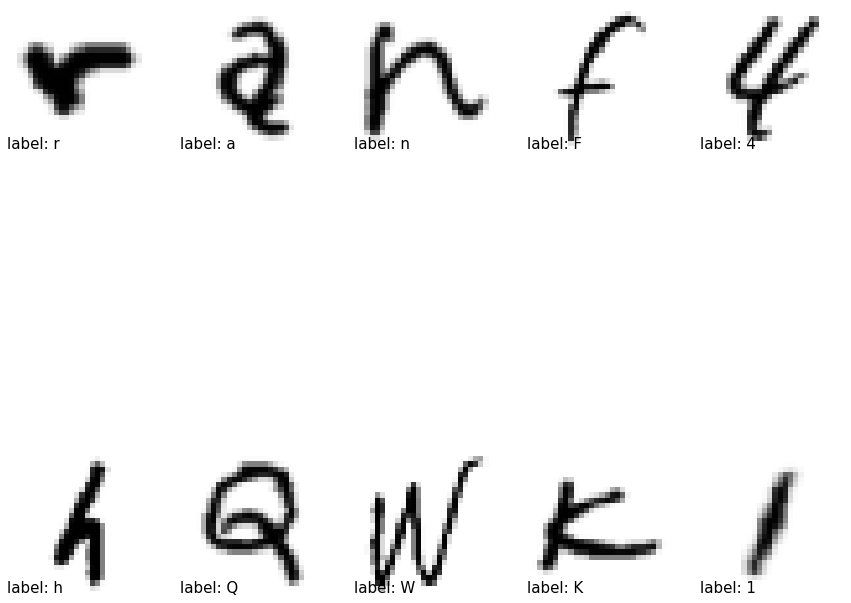

In [60]:
def plot_data(X, Y, columns, rows, pred=None):
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(columns * rows):
        img = np.transpose(np.asarray((255 - X[i].cpu()).reshape(28, 28)))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap="gray")
        ax = plt.gca()
        ax.axis('off')
        ax.text(0, 0, "label: " + chr(Y[i]), size=15, ha="left", va="bottom", transform=ax.transAxes)
        if pred != None:
            ax.text(1, 0, "pred: " + chr(pred[i]), size=15, ha="right", va="bottom", transform=ax.transAxes)
    plt.show()
plot_data(X_train[:10], Y_train[:10], 5, 2)

In [7]:
#@title k-nearest neighbors (k-NN)
def knn(dataset, labels, images, k, batch_size):
    if images.dim() != 2:
        raise ValueError("[!] images should have 2 dimensions. Index with X_test[:1] instead of X_test[0]")
    nm_of_images = images.shape[0]
    guesses = ()
    with torch.no_grad():
        for i in range(0, nm_of_images, batch_size):
            batch = images[i:i+batch_size]
            batch = batch.reshape((-1, 28*28))
            dists = torch.cdist(X_train, batch)
            topk_val, topk_idx = dists.topk(k, dim=0, largest=False)
            guess, _ = torch.mode(Y_train[topk_idx], dim=0)
            guesses += (guess,)
    return torch.cat(guesses, dim=0)


In [8]:
#@title k-nearest neighbors (k-NN) one time run with form
k = 3 #@param {type:"slider", min:0, max:10, step:1}
batch_size = 10000 #@param {type:"slider", min:0, max:100000, step:1}

result = knn(X_train, Y_train, X_test, k, batch_size)
number_of_correct = torch.sum(result == Y_test)

print("With k={}, {} correct guesses out of {}, {:.2f}%, {} classes".format(k, number_of_correct,
                                                                len(Y_test),
                                                                number_of_correct / len(Y_test) * 100,
                                                                len(torch.unique(Y_test))))
plot_data(X_test[result!=Y_test], Y_test[result!=Y_test], 5, 2, result[result!=Y_test])
del result
del number_of_correct

With k=2, 14300 correct guesses out of 18800, 76.06%, 47 classes


In [9]:
#@title k-nearest neighbors (k-NN) tests
for k in range(1, 8):
    result = knn(X_train, Y_train, X_test, k, 10000)
    number_of_correct = torch.sum(result == Y_test)
    print("With k={}, {} correct guesses out of {}, {:.2f}%, {} classes".format(k, number_of_correct,
                                                                    len(Y_test),
                                                                    number_of_correct / len(Y_test) * 100,
                                                                    len(torch.unique(Y_test))))
    del result
    del number_of_correct

With k=1, 14452 correct guesses out of 18800, 76.87%, 47 classes
With k=2, 14300 correct guesses out of 18800, 76.06%, 47 classes
With k=3, 14667 correct guesses out of 18800, 78.02%, 47 classes
With k=4, 14723 correct guesses out of 18800, 78.31%, 47 classes
With k=5, 14751 correct guesses out of 18800, 78.46%, 47 classes
With k=6, 14715 correct guesses out of 18800, 78.27%, 47 classes
With k=7, 14739 correct guesses out of 18800, 78.40%, 47 classes


With k=3, 14667 correct guesses out of 18800, 78.02%, 47 classes


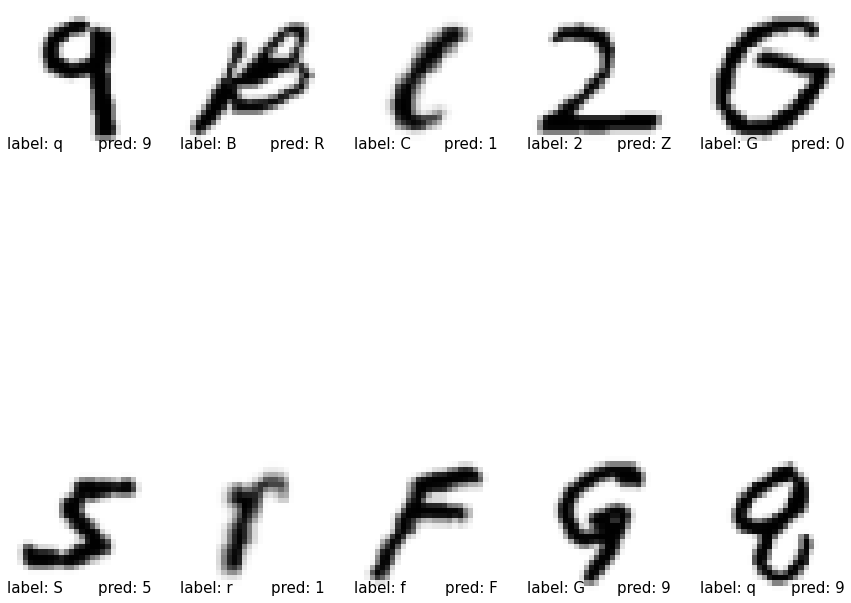

In [61]:
k = 3
batch_size = 10000

result = knn(X_train, Y_train, X_test, k, batch_size)
number_of_correct = torch.sum(result == Y_test)

print("With k={}, {} correct guesses out of {}, {:.2f}%, {} classes".format(k, number_of_correct,
                                                                len(Y_test),
                                                                number_of_correct / len(Y_test) * 100,
                                                                len(torch.unique(Y_test))))
plot_data(X_test[result!=Y_test], Y_test[result!=Y_test], 5, 2, result[result!=Y_test])

In [22]:
X_test[result!=Y_test].shape

torch.Size([4133, 784])

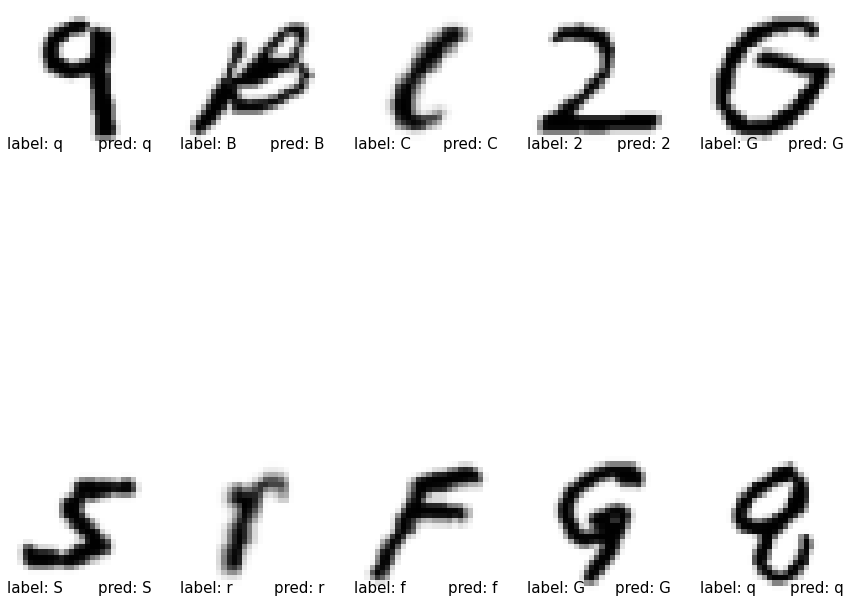

In [58]:
plot_data(X_test[result!=Y_test], Y_test[result!=Y_test], 5, 2, result[result!=Y_test])

In [10]:
def LVQ(dataset, labels, image, k):
    pass

In [11]:
#@title # Variable Inspector Widget (for debugging)
#@markdown Included for debugging

#@markdown Taken from https://github.com/jupyter-widgets/ipywidgets/blob/7.x/docs/source/examples/Variable%20Inspector.ipynb

import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

class VariableInspectorWindow(object):
    instance = None
    
    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a 
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")
        
        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell
        
        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]
        
        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)
        
    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable 
        Inspector."""
        self._box._ipython_display_()
inspector = VariableInspectorWindow(get_ipython())

In [62]:
inspector

Box(children=(HTML(value='<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>…

In [63]:
del wrong_guesses